In [1]:
# boilerplate code
import os
import re
from cStringIO import StringIO
import numpy as np
from functools import partial
import PIL.Image
import PIL.ImageOps
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

In [2]:
# creating fresh Graph and TensorFlow session
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

# Prepare input for the format expected by the graph
t_input = tf.placeholder(np.float32, name='our_input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)

# Load graph and import into graph used by our session
model_fn = 'imagenet/tensorflow_inception_graph.pb'
graph_def = tf.GraphDef.FromString(open(model_fn).read())
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [3]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print 'Number of layers', len(layers)
print 'Total number of feature channels:', sum(feature_nums)

Number of layers 59
Total number of feature channels: 7548


In [4]:
# Helper functions for TF Graph visualization
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

In [5]:
label_lookup_path = 'imagenet/imagenet_2012_challenge_label_map_proto.pbtxt'
uid_lookup_path = 'imagenet/imagenet_synset_to_human_label_map.txt'

# The id translation goes via id strings -- find translation between UID string and human-friendly names
proto_as_ascii_lines = open(uid_lookup_path).readlines()
uid_to_human = {}
p = re.compile(r'[n\d]*[ \S,]*')
for line in proto_as_ascii_lines:
    parsed_items = p.findall(line)
    uid = parsed_items[0]
    human_string = parsed_items[2]
    uid_to_human[uid] = human_string

# Get node IDs to UID strings map
proto_as_ascii_lines = open(label_lookup_path).readlines()
node_id_to_uid = {}
for line in proto_as_ascii_lines:
    if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
    if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

# Make node ID to human friendly names map
node_id_to_name = {}
for key, val in node_id_to_uid.iteritems():
    name = uid_to_human[val]
    node_id_to_name[key] = name
    
# make sure we have a name for each possible ID
for i in range(graph.get_tensor_by_name('import/softmax2:0').get_shape()[1]):
    if i not in node_id_to_name:
        node_id_to_name[i] = '???'

In [6]:
node_id_to_name[438] #Inception model has 1000 output classes. Class 438 represents a bird:

'European gallinule, Porphyrio porphyrio'

In [7]:
# Helper function to get a named layer from the graph
def T(layer_name):
    return graph.get_tensor_by_name("import/%s:0" % layer_name)

softmax = T('softmax2')

def prep_img(filename):
    size = (224, 224)
    img = PIL.Image.open(filename)
    img.thumbnail(size, PIL.Image.ANTIALIAS)
    thumb = PIL.ImageOps.fit(img, size, PIL.Image.ANTIALIAS, (0.5, 0.5))
    return np.float32(thumb)

# Print the 10 top predictions for a given image
def prediction(filename, k=10):
    img = prep_img(filename)
    # Load, resize, and central square crop the image.
    
    # Compute predictions
    predictions = sess.run(softmax, {t_input: img})
    predictions = np.squeeze(predictions)

    top_k = predictions.argsort()[-k:][::-1]
    for node_id in top_k:
        human_string = node_id_to_name[node_id]
        score = predictions[node_id]
        print '%s (score = %.5f)' % (human_string, score)
        
# Helper function: Display an image
def showarray(a, fmt='jpeg', size=None):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = StringIO()
    img = PIL.Image.fromarray(a)
    if size is not None:
        img = img.resize((size,size))
    img.save(f, fmt)
    display(Image(data=f.getvalue()))

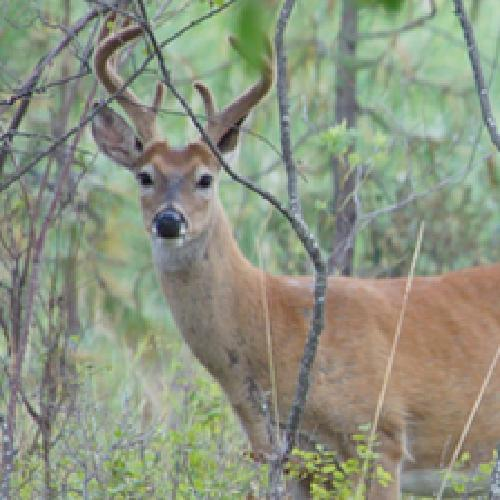

impala, Aepyceros melampus (score = 0.58144)
gazelle (score = 0.17720)
lynx, catamount (score = 0.08341)
dhole, Cuon alpinus (score = 0.07029)
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor (score = 0.03539)
red wolf, maned wolf, Canis rufus, Canis niger (score = 0.02009)
dingo, warrigal, warragal, Canis dingo (score = 0.01209)
ibex, Capra ibex (score = 0.01047)
wallaby, brush kangaroo (score = 0.00497)
hare (score = 0.00130)


In [8]:
showarray(prep_img('testimages/deer.jpg')/255., size=500) #antelope
prediction('testimages/deer.jpg')

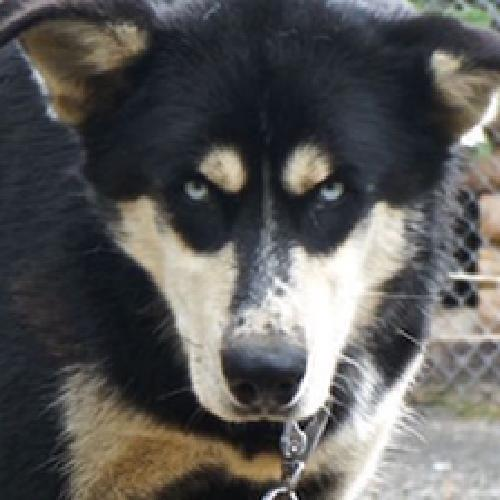

kelpie (score = 0.48227)
Eskimo dog, husky (score = 0.30863)
Siberian husky (score = 0.12348)
dingo, warrigal, warragal, Canis dingo (score = 0.04205)
malamute, malemute, Alaskan malamute (score = 0.01326)
timber wolf, grey wolf, gray wolf, Canis lupus (score = 0.00914)
Appenzeller (score = 0.00658)
dhole, Cuon alpinus (score = 0.00653)
red wolf, maned wolf, Canis rufus, Canis niger (score = 0.00314)
EntleBucher (score = 0.00191)


In [9]:
showarray(prep_img('testimages/dog.jpg')/255., size=500) #Almost Correct classification
prediction('testimages/dog.jpg')

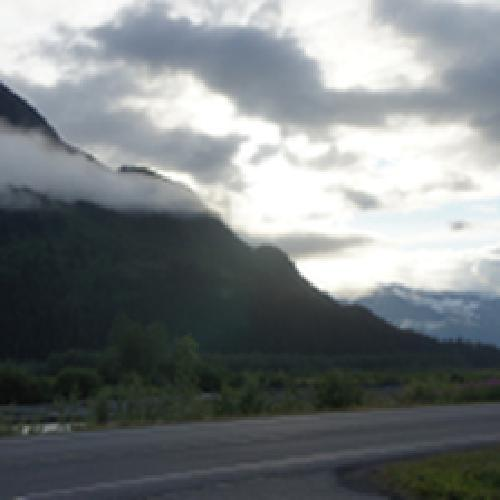

valley, vale (score = 0.40203)
alp (score = 0.38084)
volcano (score = 0.08603)
promontory, headland, head, foreland (score = 0.03863)
lakeside, lakeshore (score = 0.03679)
seashore, coast, seacoast, sea-coast (score = 0.01268)
geyser (score = 0.01249)
cliff, drop, drop-off (score = 0.00477)
mountain tent (score = 0.00312)
sandbar, sand bar (score = 0.00295)


In [10]:
showarray(prep_img('testimages/mountains.jpg')/255., size=500) #Correct classification
prediction('testimages/mountains.jpg')

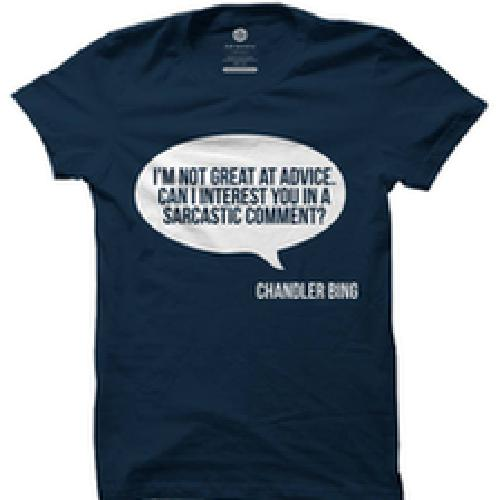

jersey, T-shirt, tee shirt (score = 0.99938)
maillot (score = 0.00045)
sweatshirt (score = 0.00014)
bulletproof vest (score = 0.00002)
apron (score = 0.00001)
sleeping bag (score = 0.00000)
plastic bag (score = 0.00000)
pajama, pyjama, pj's, jammies (score = 0.00000)
packet (score = 0.00000)
diaper, nappy, napkin (score = 0.00000)


In [11]:
showarray(prep_img('testimages/tshirt.jpg')/255., size=500) #Correct classification
prediction('testimages/tshirt.jpg')

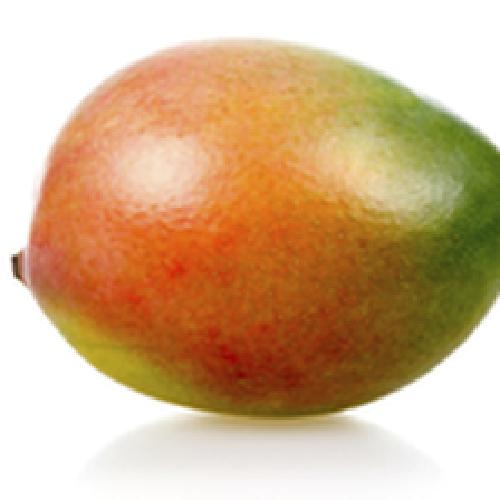

Granny Smith (score = 0.31502)
croquet ball (score = 0.18123)
orange (score = 0.17135)
lemon (score = 0.15191)
pomegranate (score = 0.08000)
banana (score = 0.02487)
spaghetti squash (score = 0.02206)
fig (score = 0.01641)
buckeye, horse chestnut, conker (score = 0.01320)
maraca (score = 0.00539)


In [12]:
showarray(prep_img('testimages/mango.jpg')/255., size=500) #Incorrect classification
prediction('testimages/mango.jpg')

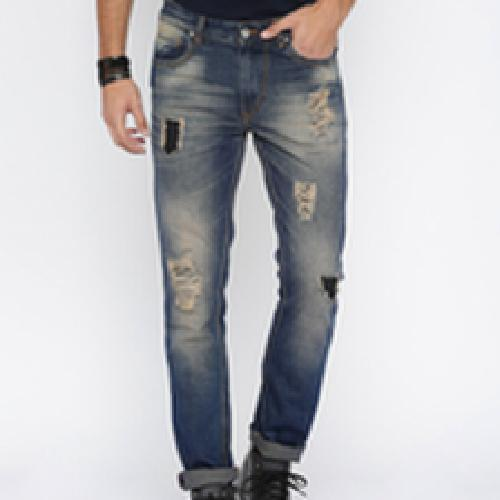

jean, blue jean, denim (score = 0.98944)
cowboy boot (score = 0.00205)
knee pad (score = 0.00147)
suit, suit of clothes (score = 0.00099)
pajama, pyjama, pj's, jammies (score = 0.00083)
cardigan (score = 0.00053)
sweatshirt (score = 0.00038)
bulletproof vest (score = 0.00035)
Windsor tie (score = 0.00027)
stole (score = 0.00026)


In [13]:
showarray(prep_img('testimages/jeans.jpg')/255., size=500) #Correct classification
prediction('testimages/jeans.jpg')

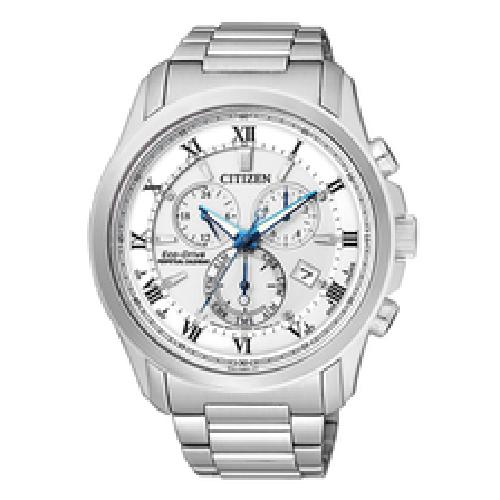

analog clock (score = 0.68373)
stopwatch, stop watch (score = 0.26558)
wall clock (score = 0.03169)
magnetic compass (score = 0.01546)
digital watch (score = 0.00212)
barometer (score = 0.00115)
digital clock (score = 0.00019)
sundial (score = 0.00004)
bell cote, bell cot (score = 0.00002)
rule, ruler (score = 0.00001)


In [14]:
showarray(prep_img('testimages/watch.jpg')/255., size=500) #Confused classification
prediction('testimages/watch.jpg')

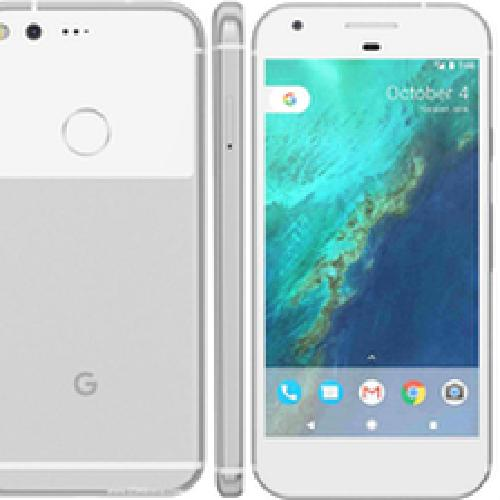

hand-held computer, hand-held microcomputer (score = 0.41871)
cellular telephone, cellular phone, cellphone, cell, mobile phone (score = 0.23690)
desktop computer (score = 0.11170)
iPod (score = 0.09266)
modem (score = 0.04208)
hard disc, hard disk, fixed disk (score = 0.01791)
monitor (score = 0.01447)
screen, CRT screen (score = 0.01428)
oscilloscope, scope, cathode-ray oscilloscope, CRO (score = 0.01028)
projector (score = 0.00970)


In [15]:
showarray(prep_img('testimages/googlepixel.jpg')/255., size=500) #Incorrect classification
prediction('testimages/googlepixel.jpg')

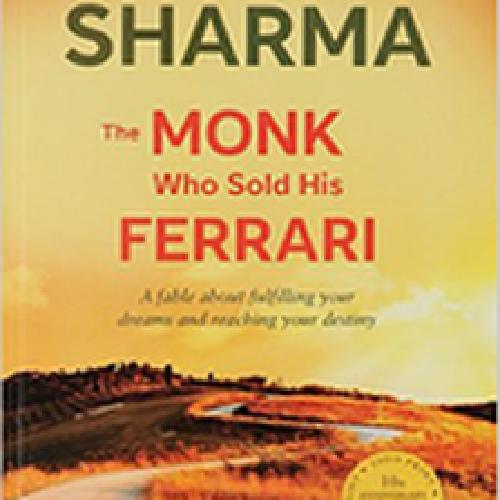

book jacket, dust cover, dust jacket, dust wrapper (score = 0.84354)
packet (score = 0.14232)
comic book (score = 0.00309)
mousetrap (score = 0.00165)
menu (score = 0.00137)
carton (score = 0.00104)
sunscreen, sunblock, sun blocker (score = 0.00058)
envelope (score = 0.00055)
binder, ring-binder (score = 0.00052)
bakery, bakeshop, bakehouse (score = 0.00045)


In [16]:
showarray(prep_img('testimages/book.jpg')/255., size=500) #Almost Correct classification
prediction('testimages/book.jpg')